In [ ]:
cd ./drive/MyDrive

[Errno 2] No such file or directory: './drive/MyDrive'
/content


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install -q tensorflow-addons
!pip install -q git+https://github.com/hoyso48/tf-utils@main

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 7.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
inflect 7.5.0 requires typeguard>=4.0.1, but you have typeguard 2.13.3 which is incompatible.
  Preparing metadata (setup.py) ... done


In [3]:
# 0️⃣ Очистка потенциально конфликтных пакетов
!pip uninstall -y -q keras keras-core keras-nightly keras-2 jax jaxlib chex tensorstore

# 1️⃣ Совместимые версии NumPy и ml‑dtypes (под TF 2.15)
!pip install -q "numpy==1.24.3" "ml-dtypes==0.2.0"

# 2️⃣ TensorFlow 2.15 + TensorFlow‑Addons 0.23 (работает с tf.keras)
!pip install -q "tensorflow==2.15.0" "tensorflow-addons==0.23.0"

# 3️⃣ Перезапускаем runtime (Runtime → Restart)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 114.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 42.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
orbax-checkpoint 0.11.13 requires jax>=0.5.0, which is not installed.
orbax-checkpoint 0.11.13 requires tensorstore>=0.1.71, which is not installed.
tensorflow 2.18.0 requires keras>=3.5.0, which is not installed.
dopamine-rl 4.1.2 requires jax>=0.1.72, which is not installed.
dopamine-rl 4.1.2 requires jaxlib>=0.1.51, which is not installed.
optax 0.2.4 requires chex>=0.1.87, which is not installed.
optax 0.2.4 requires jax>=0.4.27, which is not installed.
optax 0.2.4 requires jaxlib>=0.4.27, which is not installed.
flax 0.10.6 requires jax>=0.5.1, which is not installed.
flax 0.10.6 requires tensorstore, which is not installed.
tensorflow 2.18.0 requires ml-

In [4]:
!pip install opencv-python

In [1]:
import zipfile
import os

zip_path = "/content/drive/MyDrive/Colab Notebooks/asl-signs.zip"

extract_path = "/content/asl-signs"
os.makedirs(extract_path, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)
print("Распаковка завершена!")

Распаковка завершена!


In [2]:
import os, gc, json, random
import numpy as np, pandas as pd, tensorflow as tf
from types import SimpleNamespace

def seed_everything(seed=42):
    random.seed(seed); np.random.seed(seed); tf.random.set_seed(seed)

try:
    resolver = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.tpu.experimental.initialize_tpu_system(resolver)
    STRATEGY = tf.distribute.TPUStrategy(resolver)
except ValueError:
    gpus = tf.config.list_physical_devices('GPU')
    STRATEGY = tf.distribute.MirroredStrategy() if gpus else tf.distribute.get_strategy()

In [3]:
DATA_DIR = '/content/asl-signs'

train_df = pd.read_csv(f'{DATA_DIR}/train.csv')
with open(f'{DATA_DIR}/sign_to_prediction_index_map.json') as f:
    sign2idx = json.load(f)
train_df['label'] = train_df['sign'].map(sign2idx)

train_df['path'] = (DATA_DIR + '/' + train_df['path']).str.replace('//', '/')

SEQ_LEN, CHANNELS = 64, 543*3
NUM_CLASSES = len(sign2idx)

In [4]:
OFFSETS = {'face':0,'pose':468,'left_hand':501,'right_hand':522}
POINT_ORDER = [f'{ax}{i}' for i in range(543) for ax in 'xyz']

def load_relevant_data_subset(path):
    df = pd.read_parquet(
        path, columns=['frame','type','landmark_index','x','y','z']
    )
    df['gid'] = df['landmark_index'] + df['type'].map(OFFSETS)
    df = (df.pivot_table(index='frame', columns='gid', values=['x','y','z'])
            .sort_index(axis=1))
    df.columns = [f'{c}{g}' for c,g in df.columns]
    df = df.reindex(columns=POINT_ORDER).fillna(0.)
    lm = df.to_numpy('float32')*2.0 - 1.0       # нормализация [-1;1]
    t = lm.shape[0]
    if t < SEQ_LEN:
        lm = np.pad(lm, ((0, SEQ_LEN-t),(0,0)), constant_values=0.)
    else:
        lm = lm[:SEQ_LEN]
    return lm                                   # (64,1629)

def tf_load_clip(p):
    clip = tf.numpy_function(
        lambda x: load_relevant_data_subset(x.decode()), [p], tf.float32)
    clip.set_shape([SEQ_LEN, CHANNELS])
    return clip

def make_dataset(df, batch, shuffle=True, repeat=False):
    paths  = df['path'].values.astype('S')
    labels = tf.one_hot(df['label'].values, NUM_CLASSES)
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    if shuffle: ds = ds.shuffle(len(df), reshuffle_each_iteration=True)
    ds = ds.map(lambda p,y:(tf_load_clip(p), y),
                num_parallel_calls=tf.data.AUTOTUNE)
    if repeat: ds = ds.repeat()
    return ds.batch(batch).prefetch(tf.data.AUTOTUNE)

In [5]:
CFG = SimpleNamespace(
    seed=42, batch=64, lr=1e-3, epochs=12,
    dim=192, warmup=0.1, wd=1e-4
)

seed_everything(CFG.seed)

val_df = train_df.sample(frac=0.05, random_state=CFG.seed)
trn_df = train_df.drop(val_df.index)

steps_per_epoch = len(trn_df)//CFG.batch
val_steps = len(val_df)//CFG.batch

In [6]:
class MultiHeadSelfAttention(tf.keras.layers.Layer):
    def __init__(self, dim=256, num_heads=4, dropout=0.2, **kwargs):
        super().__init__(**kwargs)
        self.dim        = dim
        self.num_heads  = num_heads
        self.head_dim   = dim // num_heads
        self.scale      = self.head_dim ** -0.5

        self.qkv  = tf.keras.layers.Dense(3 * dim, use_bias=False)
        self.proj = tf.keras.layers.Dense(dim, use_bias=False)
        self.drop = tf.keras.layers.Dropout(dropout)
        self.supports_masking = True

    def call(self, x, mask=None):                      # x: (B,T,C)
        B, T = tf.shape(x)[0], tf.shape(x)[1]

        qkv = self.qkv(x)                              # (B,T,3*dim)
        qkv = tf.reshape(qkv, [B, T, 3, self.num_heads, self.head_dim])
        qkv = tf.transpose(qkv, [2, 0, 3, 1, 4])       # (3,B,H,T,D)
        q, k, v = tf.unstack(qkv, 3, axis=0)           # (B,H,T,D) ×3

        attn = tf.matmul(q, k, transpose_b=True) * self.scale  # (B,H,T,T)

        if mask is not None:                           # mask: (B,T)
            mask = mask[:, None, None, :]              # (B,1,1,T)
            attn = tf.where(mask, -1e9, attn)          # set –∞

        attn = tf.nn.softmax(attn, axis=-1)
        attn = self.drop(attn)

        x = tf.matmul(attn, v)
        x = tf.transpose(x, [0, 2, 1, 3])
        x = tf.reshape(x, [B, T, self.dim])

        return self.proj(x)


def TransformerBlock(dim=256, num_heads=4, expand=4,
                     attn_dropout=0.2, drop_rate=0.2,
                     activation='swish'):
    def block(inputs):
        x = tf.keras.layers.BatchNormalization(momentum=0.95)(inputs)
        x = MultiHeadSelfAttention(dim, num_heads, attn_dropout)(x)
        x = tf.keras.layers.Dropout(drop_rate, noise_shape=(None,1,1))(x)
        x = tf.keras.layers.Add()([inputs, x])
        attn_out = x

        x = tf.keras.layers.BatchNormalization(momentum=0.95)(x)
        x = tf.keras.layers.Dense(dim*expand, activation=activation, use_bias=False)(x)
        x = tf.keras.layers.Dense(dim, use_bias=False)(x)
        x = tf.keras.layers.Dropout(drop_rate, noise_shape=(None,1,1))(x)
        return tf.keras.layers.Add()([attn_out, x])
    return block

class CausalDWConv1D(tf.keras.layers.Layer):
    def __init__(self, ksize=17, **kw):
        super().__init__(**kw)
        self.ksize = ksize
        self.dw = tf.keras.layers.DepthwiseConv2D(
            (ksize, 1), padding='valid', use_bias=False)

    def call(self, x):
        # x: [B, T, C]
        x = tf.pad(x, [[0, 0], [self.ksize - 1, 0], [0, 0]])
        x = tf.expand_dims(x, 2)
        x = self.dw(x)
        return tf.squeeze(x, 2)


class ECA(tf.keras.layers.Layer):
    """Efficient Channel Attention"""
    def __init__(self, k_size=3, **kw):
        super().__init__(**kw)
        self.conv = tf.keras.layers.Conv1D(1, k_size, padding='same',
                                           use_bias=False)

    def call(self, x):
        y = tf.reduce_mean(x, axis=1, keepdims=True)
        y = self.conv(y)
        y = tf.keras.activations.sigmoid(y)
        return x * y

def Conv1DBlock(dim, ksize, drop_rate=0.2):
        x = tf.keras.layers.Dense(dim*2, activation='swish', use_bias=False)(inputs)
        x = CausalDWConv1D(ksize)(x)
        x = tf.keras.layers.BatchNormalization(momentum=0.95)(x)
        x = ECA()(x)
        x = tf.keras.layers.Dense(dim, use_bias=False)(x)
        x = tf.keras.layers.Dropout(drop_rate, noise_shape=(None,1,1))(x)
        return tf.keras.layers.Add()([inputs, x])
    return block

class LateDropout(tf.keras.layers.Layer):
    def __init__(self, rate=0.5, start_step=0, **kw):
        super().__init__(**kw)
        self.rate  = rate
        self.start = start_step
        self.do    = tf.keras.layers.Dropout(rate)

    def call(self, x, training=None):
        if training:
            step = tf.summary.experimental.get_step()
            if step is None or step < self.start:
                training = False
        return self.do(x, training=training)


def get_model(max_len=64, dropout_step=0, dim=192):
    inp = tf.keras.Input((max_len, CHANNELS))
    x = tf.keras.layers.Masking(mask_value=PAD)(inp)

    ksize = 17
    x = tf.keras.layers.Dense(dim, use_bias=False, name='stem_conv')(x)
    x = tf.keras.layers.BatchNormalization(momentum=0.95, name='stem_bn')(x)

    for _ in range(3):
        x = Conv1DBlock(dim, ksize, drop_rate=0.2)(x)
    x = TransformerBlock(dim, expand=2)(x)

    for _ in range(3):
        x = Conv1DBlock(dim, ksize, drop_rate=0.2)(x)
    x = TransformerBlock(dim, expand=2)(x)

    if dim == 384:
        for _ in range(3):
            x = Conv1DBlock(dim, ksize, drop_rate=0.2)(x)
        x = TransformerBlock(dim, expand=2)(x)
        for _ in range(3):
            x = Conv1DBlock(dim, ksize, drop_rate=0.2)(x)
        x = TransformerBlock(dim, expand=2)(x)

    x = tf.keras.layers.Dense(dim*2, name='top_conv')(x)
    x = tf.keras.layers.GlobalAveragePooling1D()(x)
    x = LateDropout(0.8, start_step=dropout_step)(x)
    out = tf.keras.layers.Dense(NUM_CLASSES, name='classifier')(x)
    return tf.keras.Model(inp, out)


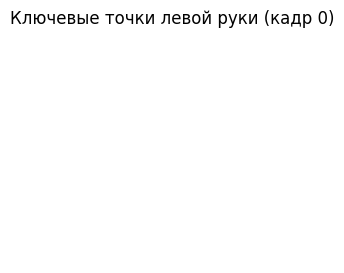

In [10]:
import matplotlib.pyplot as plt, pandas as pd
sample_path = train_df['path'].iloc[0]
raw = pd.read_parquet(sample_path)
plt.figure(figsize=(3,3))
plt.scatter(frame0['x'], -frame0['y'], s=20)
for i,(x,y) in enumerate(zip(frame0['x'], frame0['y'])):
    plt.text(x, -y, str(i), fontsize=7)
plt.title('Ключевые точки левой руки (кадр 0)')
plt.axis('off')
plt.show()

In [7]:
SEQ_LEN   = 64
CHANNELS  = 543 * 3
PAD       = 0.0
NUM_CLASSES = len(sign2idx)


with STRATEGY.scope():
    model = get_model(max_len=SEQ_LEN, dim=CFG.dim)
    optimizer = tf.keras.optimizers.AdamW(CFG.lr, weight_decay=CFG.wd)
    model.compile(optimizer,
                  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])

train_ds = make_dataset(trn_df, CFG.batch, shuffle=True, repeat=True)
val_ds   = make_dataset(val_df, CFG.batch, shuffle=False, repeat=False)

import os, pathlib, tensorflow as tf

SAVE_DIR = pathlib.Path('/content/drive/MyDrive/Colab Notebooks/checkpoints')
SAVE_DIR.mkdir(parents=True, exist_ok=True)

ckpt_all = tf.keras.callbacks.ModelCheckpoint(
    filepath=str(SAVE_DIR / 'epoch-{epoch:02d}_valAcc-{val_accuracy:.3f}.h5'),
    monitor='val_accuracy',
    save_best_only=False,
    save_weights_only=True,
    verbose=0
)

ckpt_best = tf.keras.callbacks.ModelCheckpoint(
    filepath=str(SAVE_DIR / 'best.h5'),
    monitor='val_accuracy',
    save_best_only=True,
    save_weights_only=True,
    mode='max',
    verbose=1
)

csv_log = tf.keras.callbacks.CSVLogger(
    str(SAVE_DIR / 'train_log.csv'), append=True
)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=CFG.epochs,
    steps_per_epoch=steps_per_epoch,
    validation_steps=val_steps,
    callbacks=[ckpt_all, ckpt_best, csv_log]
)


Epoch 1/12


KeyboardInterrupt: 

In [ ]:
import pathlib

SEQ_LEN   = 64
CHANNELS  = 543 * 3
PAD       = 0.0
NUM_CLASSES = len(sign2idx)


CFG = SimpleNamespace(
    seed          = 42,
    batch         = 64,
    lr            = 1e-4,
    wd            = 1e-4,
    epochs        = 20,
    resume_epoch  = 15,
    dim           = 192,
)


seed_everything(CFG.seed)

steps_per_epoch = len(trn_df)//CFG.batch
val_steps       = len(val_df)//CFG.batch

with STRATEGY.scope():
    model = get_model(max_len=SEQ_LEN, dim=CFG.dim)
    opt   = tf.keras.optimizers.AdamW(CFG.lr, weight_decay=CFG.wd)
    model.compile(opt,
                  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])


SAVE_DIR = pathlib.Path('/content/drive/MyDrive/Colab Notebooks/checkpoints')
SAVE_DIR.mkdir(parents=True, exist_ok=True)

ckpt_pattern = str(SAVE_DIR / 'epoch-{epoch:02d}_valAcc-{val_accuracy:.3f}.h5')
ckpt_all  = tf.keras.callbacks.ModelCheckpoint(ckpt_pattern,
               monitor='val_accuracy',
               save_best_only=False,
               save_weights_only=True)

ckpt_best = tf.keras.callbacks.ModelCheckpoint(str(SAVE_DIR/'best.h5'),
               monitor='val_accuracy', mode='max',
               save_best_only=True, save_weights_only=True, verbose=1)

csv_log   = tf.keras.callbacks.CSVLogger(str(SAVE_DIR/'train_log.csv'),
               append=True)


if CFG.resume_epoch > 0:
    resume_file = SAVE_DIR / f'epoch-15_valAcc-0.606.h5'
    matches = sorted(SAVE_DIR.glob(resume_file.name))
    if not matches:
        raise FileNotFoundError(f'не найден чек-пойнт для эпохи {CFG.resume_epoch}')
    model.load_weights(matches[0])
    print(f'загружены веса {matches[0].name}')


history = model.fit(
    train_ds,
    validation_data = val_ds,
    epochs          = CFG.epochs,
    initial_epoch   = CFG.resume_epoch,
    steps_per_epoch = steps_per_epoch,
    validation_steps= val_steps,
    callbacks       = [ckpt_all, ckpt_best, csv_log],
)


✅ загружены веса epoch-15_valAcc-0.606.h5
Epoch 16/20
1056/1402 [=====================>........] - ETA: 10:11 - loss: 0.8707 - accuracy: 0.7790

Сырые данные (первые 5 точек):
Empty DataFrame
Columns: [frame, row_id, type, landmark_index, x, y, z]
Index: []


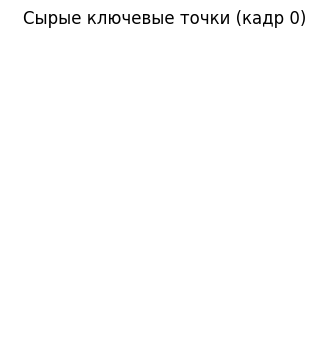

Обработанные данные (первые 5 точек):
[[0.49440014 0.38046983]
 [0.49601725 0.3507348 ]
 [0.5008185  0.35934305]
 [0.48978812 0.32177976]
 [0.4953035  0.341821  ]]


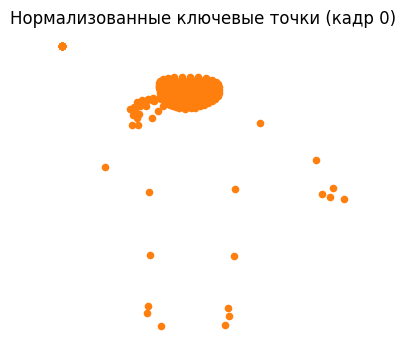

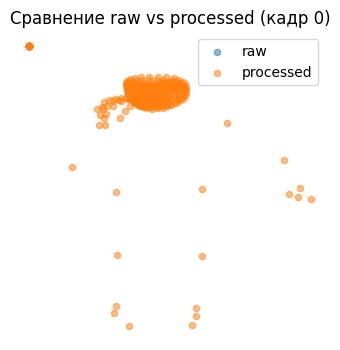

In [15]:
# ── Визуализация «сырых» и «готовых» данных ─────────────────────────
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# 1) Выбираем случайный пример
sample_path = train_df['path'].iloc[0]

# 2) Читаем Parquet (сырые точки, диапазон 0..1)
raw = pd.read_parquet(sample_path)
# берём кадр 0
frame0 = raw[raw['frame']==0]
# выведем 5 первых строк для отладки
print("Сырые данные (первые 5 точек):")
print(frame0.head())

# строим scatter сырого кадра
plt.figure(figsize=(4,4))
plt.scatter(frame0['x'], -frame0['y'], s=20, c='tab:blue', label='raw')
plt.title('Сырые ключевые точки (кадр 0)')
plt.axis('off')
plt.show()

# 3) Загружаем предобработанный тензор через вашу функцию
proc = load_relevant_data_subset(sample_path)    # shape = (64, 1629)
# выделяем первый кадр и превращаем в (543,3)
pts = proc[0].reshape(543,3)
x = (pts[:,0] + 1)/2   # если нужно вернуть [0..1]
y = (pts[:,1] + 1)/2

# выводим первые 5
print("Обработанные данные (первые 5 точек):")
print(np.stack([x,y],axis=1)[:5])

# строим scatter обработанного кадра
plt.figure(figsize=(4,4))
plt.scatter(x, -y, s=20, c='tab:orange', label='processed')
plt.title('Нормализованные ключевые точки (кадр 0)')
plt.axis('off')
plt.show()

# 4) Наложим оба рисунка в один для сравнения
plt.figure(figsize=(4,4))
plt.scatter(frame0['x'], -frame0['y'], s=20, c='tab:blue',   alpha=0.5, label='raw')
plt.scatter(   x      ,    -y       , s=20, c='tab:orange', alpha=0.5, label='processed')
plt.legend(loc='upper right')
plt.title('Сравнение raw vs processed (кадр 0)')
plt.axis('off')
plt.show()


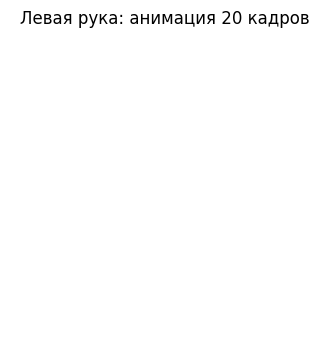

In [18]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np

# Загрузка одного примера через функцию предобработки
sample_path = train_df['path'].iloc[0]
proc = load_relevant_data_subset(sample_path)  # (64, 1629)
# Разбиваем на кадры T×543×3
frames = proc.reshape(64, 543, 3)

# Индексы для левой руки в глобальном массиве: 501–521 (21 точка)
start, end = 501, 522
hand_seq = frames[:, start:end, :2]  # берём только x,y

fig, ax = plt.subplots(figsize=(4,4))
scat = ax.scatter([], [], s=20, c='tab:green')
ax.set_title('Левая рука: анимация 20 кадров')
ax.axis('off')

# init-функция для анимации
def init():
    scat.set_offsets(np.empty((0,2)))
    return scat,

# обновление для каждого кадра
def update(i):
    pts = hand_seq[i]
    scat.set_offsets(np.column_stack([pts[:,0], -pts[:,1]]))
    return scat,

ani = animation.FuncAnimation(
    fig, update, frames=20, init_func=init,
    interval=150, blit=True
)

# Для Colab:
from IPython.display import HTML
HTML(ani.to_jshtml())

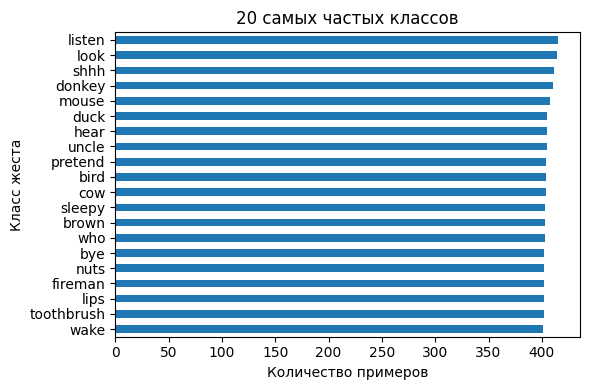

In [13]:
# 3) Распределение примеров по классам (топ-20 самых частых)
vc = train_df['sign'].value_counts().iloc[:20][::-1]
plt.figure(figsize=(6,4))
vc.plot.barh()
plt.title('20 самых частых классов')
plt.xlabel('Количество примеров')
plt.ylabel('Класс жеста')
plt.tight_layout()
plt.show()

Вариант автора

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
import matplotlib as mpl
import tensorflow.keras.mixed_precision as mixed_precision

from tqdm.autonotebook import tqdm
import sklearn

from tf_utils.schedules import OneCycleLR, ListedLR
from tf_utils.callbacks import Snapshot, SWA
from tf_utils.learners import FGM, AWP

import os
import time
import pickle
import math
import random
import sys
import cv2
import gc
import glob
import datetime

print(f'Tensorflow Version: {tf.__version__}')
print(f'Python Version: {sys.version}')

/usr/local/lib/python3.11/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
<ipython-input-2-f8b6455d81d0>:9: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


Tensorflow Version: 2.15.0
Python Version: 3.11.12 (main, Apr  9 2025, 08:55:54) [GCC 11.4.0]


In [ ]:
# Seed all random number generators
def seed_everything(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

def get_strategy(device='TPU'):
    if "TPU" in device:
        tpu = 'local' if device=='TPU-VM' else None
        print("connecting to TPU...")
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect(tpu=tpu)
        strategy = tf.distribute.TPUStrategy(tpu)
        IS_TPU = True

    if device == "GPU"  or device=="CPU":
        ngpu = len(tf.config.experimental.list_physical_devices('GPU'))
        if ngpu>1:
            print("Using multi GPU")
            strategy = tf.distribute.MirroredStrategy()
        elif ngpu==1:
            print("Using single GPU")
            strategy = tf.distribute.get_strategy()
        else:
            print("Using CPU")
            strategy = tf.distribute.get_strategy()
            CFG.device = "CPU"

    if device == "GPU":
        print("Num GPUs Available: ", ngpu)

    AUTO     = tf.data.experimental.AUTOTUNE
    REPLICAS = strategy.num_replicas_in_sync
    print(f'REPLICAS: {REPLICAS}')

    return strategy, REPLICAS, IS_TPU

STRATEGY, N_REPLICAS, IS_TPU = get_strategy()

connecting to TPU...


ValueError: Please provide a TPU Name to connect to.

In [ ]:
DATA_DIR = '/content/asl-signs'        # папка, где лежат распакованные файлы
TRAIN_CSV = f'{DATA_DIR}/train.csv'
TEST_CSV  = f'{DATA_DIR}/test.csv'
JSON_DIR  = f'{DATA_DIR}/train_landmark_files'

import pandas as pd
train_df = pd.read_csv(TRAIN_CSV)
print(train_df.head())

FileNotFoundError: [Errno 2] No such file or directory: '/content/asl-signs/test.csv'

In [ ]:
# ⬇️ 1. Импорты и базовые пути
import os, json, pandas as pd, tensorflow as tf

DATA_DIR   = '/content/asl-signs'                 # корень датасета
TRAIN_CSV  = os.path.join(DATA_DIR, 'train.csv')
JSON_ROOT  = os.path.join(DATA_DIR, 'train_landmark_files')  # подпапки с *.json

# ⬇️ 2. Загружаем CSV с метаданными жестов
train_df = pd.read_csv(TRAIN_CSV)                 # 94 477 строк

# ⬇️ 3. Словарь «жест → индекс класса»
with open(os.path.join(DATA_DIR, 'sign_to_prediction_index_map.json')) as f:
    sign2idx = json.load(f)

# ⬇️ 4. Числовой столбец label
train_df['label'] = train_df['sign'].map(sign2idx)

# ⬇️ 5. Полный путь к JSON-клипу для каждого sequence_id
#    (в CSV уже есть столбец "path" с относительным путём — пользуемся им,
#     иначе строим путь сами по sequence_id)
if 'path' in train_df.columns:
    train_df['path'] = train_df['path'].apply(
        lambda p: os.path.join(DATA_DIR, p)        # → /content/asl-signs/train_landmark_files/…
    )
else:
    train_df['path'] = train_df['sequence_id'].apply(
        lambda sid: os.path.join(JSON_ROOT, f'{sid}.json')
    )

# ⬇️ 6. Проверяем, что все файлы на месте
missing = train_df[~train_df['path'].apply(tf.io.gfile.exists)]
print(f'Отсутствующих JSON-файлов: {len(missing)}')   # должно быть 0

# ⬇️ 7. Пара полезных констант
NUM_CLASSES = len(sign2idx)
CHANNELS    = 543 * 3          # 1629 (x, y, z для 543 точек)

train_df.head()


Отсутствующих JSON-файлов: 0


,path,participant_id,sequence_id,sign,label
0,/content/asl-signs/train_landmark_files/26734/...,26734,1000035562,blow,25
1,/content/asl-signs/train_landmark_files/28656/...,28656,1000106739,wait,232
2,/content/asl-signs/train_landmark_files/16069/...,16069,100015657,cloud,48
3,/content/asl-signs/train_landmark_files/25571/...,25571,1000210073,bird,23
4,/content/asl-signs/train_landmark_files/62590/...,62590,1000240708,owie,164


In [ ]:
import glob, re, numpy as np

TRAIN_FILENAMES = glob.glob(f"{DATA_DIR}/tfrecords/*.tfrecords")

def count_data_items(filenames):
    import re, numpy as np
    n = [int(re.compile(r"-([0-9]*)\.").search(f.split('/')[-1]).group(1))
         for f in filenames]
    return np.sum(n)

print(count_data_items(TRAIN_FILENAMES), len(train_df))
assert count_data_items(TRAIN_FILENAMES) == len(train_df)

0.0 94477


AssertionError: 

In [ ]:
# Train DataFrame
train_df = pd.read_csv(TRAIN_CSV)
display(train_df.head())
display(train_df.info())

,path,participant_id,sequence_id,sign
0,train_landmark_files/26734/1000035562.parquet,26734,1000035562,blow
1,train_landmark_files/28656/1000106739.parquet,28656,1000106739,wait
2,train_landmark_files/16069/100015657.parquet,16069,100015657,cloud
3,train_landmark_files/25571/1000210073.parquet,25571,1000210073,bird
4,train_landmark_files/62590/1000240708.parquet,62590,1000240708,owie


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94477 entries, 0 to 94476
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   path            94477 non-null  object
 1   participant_id  94477 non-null  int64 
 2   sequence_id     94477 non-null  int64 
 3   sign            94477 non-null  object
dtypes: int64(2), object(2)
memory usage: 2.9+ MB


None

In [ ]:
import re
def count_data_items(filenames):
    n = [int(re.compile(r"-([0-9]*)\.").search(filename.split('/')[-1]).group(1)) for filename in filenames]
    return np.sum(n)
print(count_data_items(TRAIN_FILENAMES), len(train_df))
assert count_data_items(TRAIN_FILENAMES) == len(train_df)

0.0 94477


AssertionError: 

In [ ]:
ROWS_PER_FRAME = 543
MAX_LEN = 384
CROP_LEN = MAX_LEN
NUM_CLASSES  = 250
PAD = -100.
NOSE=[
    1,2,98,327
]
LNOSE = [98]
RNOSE = [327]
LIP = [ 0,
    61, 185, 40, 39, 37, 267, 269, 270, 409,
    291, 146, 91, 181, 84, 17, 314, 405, 321, 375,
    78, 191, 80, 81, 82, 13, 312, 311, 310, 415,
    95, 88, 178, 87, 14, 317, 402, 318, 324, 308,
]
LLIP = [84,181,91,146,61,185,40,39,37,87,178,88,95,78,191,80,81,82]
RLIP = [314,405,321,375,291,409,270,269,267,317,402,318,324,308,415,310,311,312]

POSE = [500, 502, 504, 501, 503, 505, 512, 513]
LPOSE = [513,505,503,501]
RPOSE = [512,504,502,500]

REYE = [
    33, 7, 163, 144, 145, 153, 154, 155, 133,
    246, 161, 160, 159, 158, 157, 173,
]
LEYE = [
    263, 249, 390, 373, 374, 380, 381, 382, 362,
    466, 388, 387, 386, 385, 384, 398,
]

LHAND = np.arange(468, 489).tolist()
RHAND = np.arange(522, 543).tolist()

POINT_LANDMARKS = LIP + LHAND + RHAND + NOSE + REYE + LEYE #+POSE

NUM_NODES = len(POINT_LANDMARKS)
CHANNELS = 6*NUM_NODES

print(NUM_NODES)
print(CHANNELS)

def interp1d_(x, target_len, method='random'):
    length = tf.shape(x)[1]
    target_len = tf.maximum(1,target_len)
    if method == 'random':
        if tf.random.uniform(()) < 0.33:
            x = tf.image.resize(x, (target_len,tf.shape(x)[1]),'bilinear')
        else:
            if tf.random.uniform(()) < 0.5:
                x = tf.image.resize(x, (target_len,tf.shape(x)[1]),'bicubic')
            else:
                x = tf.image.resize(x, (target_len,tf.shape(x)[1]),'nearest')
    else:
        x = tf.image.resize(x, (target_len,tf.shape(x)[1]),method)
    return x

def tf_nan_mean(x, axis=0, keepdims=False):
    return tf.reduce_sum(tf.where(tf.math.is_nan(x), tf.zeros_like(x), x), axis=axis, keepdims=keepdims) / tf.reduce_sum(tf.where(tf.math.is_nan(x), tf.zeros_like(x), tf.ones_like(x)), axis=axis, keepdims=keepdims)

def tf_nan_std(x, center=None, axis=0, keepdims=False):
    if center is None:
        center = tf_nan_mean(x, axis=axis,  keepdims=True)
    d = x - center
    return tf.math.sqrt(tf_nan_mean(d * d, axis=axis, keepdims=keepdims))

class Preprocess(tf.keras.layers.Layer):
    def __init__(self, max_len=MAX_LEN, point_landmarks=POINT_LANDMARKS, **kwargs):
        super().__init__(**kwargs)
        self.max_len = max_len
        self.point_landmarks = point_landmarks

    def call(self, inputs):
        if tf.rank(inputs) == 3:
            x = inputs[None,...]
        else:
            x = inputs

        mean = tf_nan_mean(tf.gather(x, [17], axis=2), axis=[1,2], keepdims=True)
        mean = tf.where(tf.math.is_nan(mean), tf.constant(0.5,x.dtype), mean)
        x = tf.gather(x, self.point_landmarks, axis=2) #N,T,P,C
        std = tf_nan_std(x, center=mean, axis=[1,2], keepdims=True)

        x = (x - mean)/std

        if self.max_len is not None:
            x = x[:,:self.max_len]
        length = tf.shape(x)[1]
        x = x[...,:2]

        dx = tf.cond(tf.shape(x)[1]>1,lambda:tf.pad(x[:,1:] - x[:,:-1], [[0,0],[0,1],[0,0],[0,0]]),lambda:tf.zeros_like(x))

        dx2 = tf.cond(tf.shape(x)[1]>2,lambda:tf.pad(x[:,2:] - x[:,:-2], [[0,0],[0,2],[0,0],[0,0]]),lambda:tf.zeros_like(x))

        x = tf.concat([
            tf.reshape(x, (-1,length,2*len(self.point_landmarks))),
            tf.reshape(dx, (-1,length,2*len(self.point_landmarks))),
            tf.reshape(dx2, (-1,length,2*len(self.point_landmarks))),
        ], axis = -1)

        x = tf.where(tf.math.is_nan(x),tf.constant(0.,x.dtype),x)

        return x

118
708


In [ ]:
def decode_tfrec(record_bytes):
    features = tf.io.parse_single_example(record_bytes, {
        'coordinates': tf.io.FixedLenFeature([], tf.string),
        'sign': tf.io.FixedLenFeature([], tf.int64),
    })
    out = {}
    out['coordinates']  = tf.reshape(tf.io.decode_raw(features['coordinates'], tf.float32), (-1,ROWS_PER_FRAME,3))
    out['sign'] = features['sign']
    return out

def filter_nans_tf(x, ref_point=POINT_LANDMARKS):
    mask = tf.math.logical_not(tf.reduce_all(tf.math.is_nan(tf.gather(x,ref_point,axis=1)), axis=[-2,-1]))
    x = tf.boolean_mask(x, mask, axis=0)
    return x

def preprocess(x, augment=False, max_len=MAX_LEN):
    coord = x['coordinates']
    coord = filter_nans_tf(coord)
    if augment:
        coord = augment_fn(coord, max_len=max_len)
    coord = tf.ensure_shape(coord, (None,ROWS_PER_FRAME,3))

    return tf.cast(Preprocess(max_len=max_len)(coord)[0],tf.float32), tf.one_hot(x['sign'], NUM_CLASSES)

def flip_lr(x):
    x,y,z = tf.unstack(x, axis=-1)
    x = 1-x
    new_x = tf.stack([x,y,z], -1)
    new_x = tf.transpose(new_x, [1,0,2])
    lhand = tf.gather(new_x, LHAND, axis=0)
    rhand = tf.gather(new_x, RHAND, axis=0)
    new_x = tf.tensor_scatter_nd_update(new_x, tf.constant(LHAND)[...,None], rhand)
    new_x = tf.tensor_scatter_nd_update(new_x, tf.constant(RHAND)[...,None], lhand)
    llip = tf.gather(new_x, LLIP, axis=0)
    rlip = tf.gather(new_x, RLIP, axis=0)
    new_x = tf.tensor_scatter_nd_update(new_x, tf.constant(LLIP)[...,None], rlip)
    new_x = tf.tensor_scatter_nd_update(new_x, tf.constant(RLIP)[...,None], llip)
    lpose = tf.gather(new_x, LPOSE, axis=0)
    rpose = tf.gather(new_x, RPOSE, axis=0)
    new_x = tf.tensor_scatter_nd_update(new_x, tf.constant(LPOSE)[...,None], rpose)
    new_x = tf.tensor_scatter_nd_update(new_x, tf.constant(RPOSE)[...,None], lpose)
    leye = tf.gather(new_x, LEYE, axis=0)
    reye = tf.gather(new_x, REYE, axis=0)
    new_x = tf.tensor_scatter_nd_update(new_x, tf.constant(LEYE)[...,None], reye)
    new_x = tf.tensor_scatter_nd_update(new_x, tf.constant(REYE)[...,None], leye)
    lnose = tf.gather(new_x, LNOSE, axis=0)
    rnose = tf.gather(new_x, RNOSE, axis=0)
    new_x = tf.tensor_scatter_nd_update(new_x, tf.constant(LNOSE)[...,None], rnose)
    new_x = tf.tensor_scatter_nd_update(new_x, tf.constant(RNOSE)[...,None], lnose)
    new_x = tf.transpose(new_x, [1,0,2])
    return new_x

def resample(x, rate=(0.8,1.2)):
    rate = tf.random.uniform((), rate[0], rate[1])
    length = tf.shape(x)[0]
    new_size = tf.cast(rate*tf.cast(length,tf.float32), tf.int32) #(tf.cast(rate*tf.cast(length,tf.float32), tf.int32),tf.shape(x)[1])
    new_x = interp1d_(x, new_size) #tf.image.resize(x, new_size, method='bilinear')
    return new_x

def spatial_random_affine(xyz,
    scale  = (0.8,1.2),
    shear = (-0.15,0.15),
    shift  = (-0.1,0.1),
    degree = (-30,30),
):
    center = tf.constant([0.5,0.5])
    if scale is not None:
        scale = tf.random.uniform((),*scale)
        xyz = scale*xyz

    if shear is not None:
        xy = xyz[...,:2]
        z = xyz[...,2:]
        shear_x = shear_y = tf.random.uniform((),*shear)
        if tf.random.uniform(()) < 0.5:
            shear_x = 0.
        else:
            shear_y = 0.
        shear_mat = tf.identity([
            [1.,shear_x],
            [shear_y,1.]
        ])
        xy = xy @ shear_mat
        center = center + [shear_y, shear_x]
        xyz = tf.concat([xy,z], axis=-1)

    if degree is not None:
        xy = xyz[...,:2]
        z = xyz[...,2:]
        xy -= center
        degree = tf.random.uniform((),*degree)
        radian = degree/180*np.pi
        c = tf.math.cos(radian)
        s = tf.math.sin(radian)
        rotate_mat = tf.identity([
            [c,s],
            [-s, c],
        ])
        xy = xy @ rotate_mat
        xy = xy + center
        xyz = tf.concat([xy,z], axis=-1)

    if shift is not None:
        shift = tf.random.uniform((),*shift)
        xyz = xyz + shift

    return xyz

def temporal_crop(x, length=MAX_LEN):
    l = tf.shape(x)[0]
    offset = tf.random.uniform((), 0, tf.clip_by_value(l-length,1,length), dtype=tf.int32)
    x = x[offset:offset+length]
    return x

def temporal_mask(x, size=(0.2,0.4), mask_value=float('nan')):
    l = tf.shape(x)[0]
    mask_size = tf.random.uniform((), *size)
    mask_size = tf.cast(tf.cast(l, tf.float32) * mask_size, tf.int32)
    mask_offset = tf.random.uniform((), 0, tf.clip_by_value(l-mask_size,1,l), dtype=tf.int32)
    x = tf.tensor_scatter_nd_update(x,tf.range(mask_offset, mask_offset+mask_size)[...,None],tf.fill([mask_size,543,3],mask_value))
    return x

def spatial_mask(x, size=(0.2,0.4), mask_value=float('nan')):
    mask_offset_y = tf.random.uniform(())
    mask_offset_x = tf.random.uniform(())
    mask_size = tf.random.uniform((), *size)
    mask_x = (mask_offset_x<x[...,0]) & (x[...,0] < mask_offset_x + mask_size)
    mask_y = (mask_offset_y<x[...,1]) & (x[...,1] < mask_offset_y + mask_size)
    mask = mask_x & mask_y
    x = tf.where(mask[...,None], mask_value, x)
    return x

def augment_fn(x, always=False, max_len=None):
    if tf.random.uniform(())<0.8 or always:
        x = resample(x, (0.5,1.5))
    if tf.random.uniform(())<0.5 or always:
        x = flip_lr(x)
    if max_len is not None:
        x = temporal_crop(x, max_len)
    if tf.random.uniform(())<0.75 or always:
        x = spatial_random_affine(x)
    if tf.random.uniform(())<0.5 or always:
        x = temporal_mask(x)
    if tf.random.uniform(())<0.5 or always:
        x = spatial_mask(x)
    return x

def get_tfrec_dataset(tfrecords, batch_size=64, max_len=64, drop_remainder=False, augment=False, shuffle=False, repeat=False):
    # Initialize dataset with TFRecords
    ds = tf.data.TFRecordDataset(tfrecords, num_parallel_reads=tf.data.AUTOTUNE, compression_type='GZIP')
    ds = ds.map(decode_tfrec, tf.data.AUTOTUNE)
    ds = ds.map(lambda x: preprocess(x, augment=augment, max_len=max_len), tf.data.AUTOTUNE)

    if repeat:
        ds = ds.repeat()

    if shuffle:
        ds = ds.shuffle(shuffle)
        options = tf.data.Options()
        options.experimental_deterministic = (False)
        ds = ds.with_options(options)

    if batch_size:
        ds = ds.padded_batch(batch_size, padding_values=PAD, padded_shapes=([max_len,CHANNELS],[NUM_CLASSES]), drop_remainder=drop_remainder)

    ds = ds.prefetch(tf.data.AUTOTUNE)

    return ds

ds = get_tfrec_dataset(TRAIN_FILENAMES, augment=True, batch_size=1024)
for x in ds:
    temp_train = x
    break

<_ParallelMapDataset element_spec={'coordinates': TensorSpec(shape=(None, 543, 3), dtype=tf.float32, name=None), 'sign': TensorSpec(shape=(), dtype=tf.int64, name=None)}>


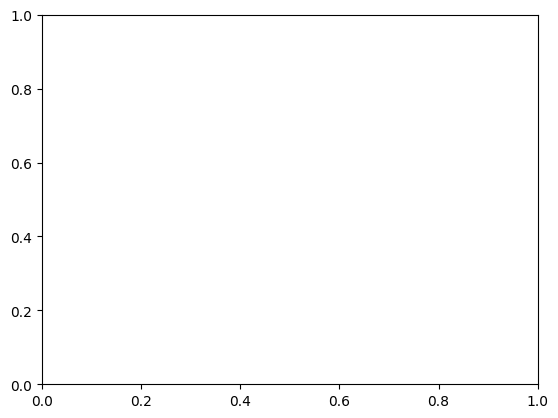

In [ ]:
from IPython.display import HTML
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation

def filter_nans(frames):
    return frames[~np.isnan(frames).all(axis=(-2,-1))]

ds = tf.data.TFRecordDataset(TRAIN_FILENAMES, num_parallel_reads=tf.data.AUTOTUNE, compression_type='GZIP')
ds = ds.map(decode_tfrec, tf.data.AUTOTUNE)
print(ds)
for x in ds:
    temp = x['coordinates'].numpy()
    if not len(filter_nans(temp[:,LHAND])) == 0:
        break

edges = [(0,1),(1,2),(2,3),(3,4),(0,5),(0,17),(5,6),(6,7),(7,8),(5,9),(9,10),(10,11),(11,12),
         (9,13),(13,14),(14,15),(15,16),(13,17),(17,18),(18,19),(19,20)]

fig, ax = plt.subplots()

def plot_frame(frame, edges=[], idxs=[]):

    frame[np.isnan(frame)] = 0
    x = list(frame[...,0])
    y = list(frame[...,1])
    if len(idxs) == 0:
        idxs = list(range(len(x)))
    ax.clear()
    ax.scatter(x, y, color='dodgerblue')
    for i in range(len(x)):
        ax.text(x[i], y[i], idxs[i])

    for edge in edges:
        ax.plot([x[edge[0]], x[edge[1]]], [y[edge[0]], y[edge[1]]], color='salmon')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

def animate_frames(frames, edges=[], idxs=[]):
    anim = FuncAnimation(fig, lambda frame: plot_frame(frame, edges, idxs), frames=frames, interval=100)
    return HTML(anim.to_jshtml())

In [ ]:
# Animate the frames
animate_frames(filter_nans(temp[:,LHAND]),edges=edges)

NameError: name 'temp' is not defined

In [ ]:
animate_frames(filter_nans(augment_fn(temp,always=True).numpy()[:,RHAND]),edges=edges)

/usr/local/lib/python3.10/dist-packages/matplotlib/animation.py:1740: UserWarning: Can not start iterating the frames for the initial draw. This can be caused by passing in a 0 length sequence for *frames*.

If you passed *frames* as a generator it may be exhausted due to a previous display or save.
  warnings.warn(


In [ ]:
animate_frames(filter_nans(temp[:,POINT_LANDMARKS]))

In [ ]:
animate_frames(filter_nans(augment_fn(temp,always=True).numpy()[:,POINT_LANDMARKS]), idxs=POINT_LANDMARKS)

In [ ]:
class ECA(tf.keras.layers.Layer):
    def __init__(self, kernel_size=5, **kwargs):
        super().__init__(**kwargs)
        self.supports_masking = True
        self.kernel_size = kernel_size
        self.conv = tf.keras.layers.Conv1D(1, kernel_size=kernel_size, strides=1, padding="same", use_bias=False)

    def call(self, inputs, mask=None):
        nn = tf.keras.layers.GlobalAveragePooling1D()(inputs, mask=mask)
        nn = tf.expand_dims(nn, -1)
        nn = self.conv(nn)
        nn = tf.squeeze(nn, -1)
        nn = tf.nn.sigmoid(nn)
        nn = nn[:,None,:]
        return inputs * nn

class LateDropout(tf.keras.layers.Layer):
    def __init__(self, rate, noise_shape=None, start_step=0, **kwargs):
        super().__init__(**kwargs)
        self.supports_masking = True
        self.rate = rate
        self.start_step = start_step
        self.dropout = tf.keras.layers.Dropout(rate, noise_shape=noise_shape)

    def build(self, input_shape):
        super().build(input_shape)
        agg = tf.VariableAggregation.ONLY_FIRST_REPLICA
        self._train_counter = tf.Variable(0, dtype="int64", aggregation=agg, trainable=False)

    def call(self, inputs, training=False):
        x = tf.cond(self._train_counter < self.start_step, lambda:inputs, lambda:self.dropout(inputs, training=training))
        if training:
          self._train_counter.assign_add(1)
        return x

class CausalDWConv1D(tf.keras.layers.Layer):
    def __init__(self,
        kernel_size=17,
        dilation_rate=1,
        use_bias=False,
        depthwise_initializer='glorot_uniform',
        name='', **kwargs):
        super().__init__(name=name,**kwargs)
        self.causal_pad = tf.keras.layers.ZeroPadding1D((dilation_rate*(kernel_size-1),0),name=name + '_pad')
        self.dw_conv = tf.keras.layers.DepthwiseConv1D(
                            kernel_size,
                            strides=1,
                            dilation_rate=dilation_rate,
                            padding='valid',
                            use_bias=use_bias,
                            depthwise_initializer=depthwise_initializer,
                            name=name + '_dwconv')
        self.supports_masking = True

    def call(self, inputs):
        x = self.causal_pad(inputs)
        x = self.dw_conv(x)
        return x

def Conv1DBlock(channel_size,
          kernel_size,
          dilation_rate=1,
          drop_rate=0.0,
          expand_ratio=2,
          se_ratio=0.25,
          activation='swish',
          name=None):
    '''
    efficient conv1d block, @hoyso48
    '''
    if name is None:
        name = str(tf.keras.backend.get_uid("mbblock"))
    # Expansion phase
    def apply(inputs):
        channels_in = tf.keras.backend.int_shape(inputs)[-1]
        channels_expand = channels_in * expand_ratio

        skip = inputs

        x = tf.keras.layers.Dense(
            channels_expand,
            use_bias=True,
            activation=activation,
            name=name + '_expand_conv')(inputs)

        # Depthwise Convolution
        x = CausalDWConv1D(kernel_size,
            dilation_rate=dilation_rate,
            use_bias=False,
            name=name + '_dwconv')(x)

        x = tf.keras.layers.BatchNormalization(momentum=0.95, name=name + '_bn')(x)

        x  = ECA()(x)

        x = tf.keras.layers.Dense(
            channel_size,
            use_bias=True,
            name=name + '_project_conv')(x)

        if drop_rate > 0:
            x = tf.keras.layers.Dropout(drop_rate, noise_shape=(None,1,1), name=name + '_drop')(x)

        if (channels_in == channel_size):
            x = tf.keras.layers.add([x, skip], name=name + '_add')
        return x

    return apply

In [ ]:
class MultiHeadSelfAttention(tf.keras.layers.Layer):
    def __init__(self, dim=256, num_heads=4, dropout=0, **kwargs):
        super().__init__(**kwargs)
        self.dim = dim
        self.scale = self.dim ** -0.5
        self.num_heads = num_heads
        self.qkv = tf.keras.layers.Dense(3 * dim, use_bias=False)
        self.drop1 = tf.keras.layers.Dropout(dropout)
        self.proj = tf.keras.layers.Dense(dim, use_bias=False)
        self.supports_masking = True

    def call(self, inputs, mask=None):
        qkv = self.qkv(inputs)
        qkv = tf.keras.layers.Permute((2, 1, 3))(tf.keras.layers.Reshape((-1, self.num_heads, self.dim * 3 // self.num_heads))(qkv))
        q, k, v = tf.split(qkv, [self.dim // self.num_heads] * 3, axis=-1)

        attn = tf.matmul(q, k, transpose_b=True) * self.scale

        if mask is not None:
            mask = mask[:, None, None, :]

        attn = tf.keras.layers.Softmax(axis=-1)(attn, mask=mask)
        attn = self.drop1(attn)

        x = attn @ v
        x = tf.keras.layers.Reshape((-1, self.dim))(tf.keras.layers.Permute((2, 1, 3))(x))
        x = self.proj(x)
        return x

def TransformerBlock(dim=256, num_heads=4, expand=4, attn_dropout=0.2, drop_rate=0.2, activation='swish'):
    def apply(inputs):
        x = inputs
        x = tf.keras.layers.BatchNormalization(momentum=0.95)(x)
        x = MultiHeadSelfAttention(dim=dim,num_heads=num_heads,dropout=attn_dropout)(x)
        x = tf.keras.layers.Dropout(drop_rate, noise_shape=(None,1,1))(x)
        x = tf.keras.layers.Add()([inputs, x])
        attn_out = x

        x = tf.keras.layers.BatchNormalization(momentum=0.95)(x)
        x = tf.keras.layers.Dense(dim*expand, use_bias=False, activation=activation)(x)
        x = tf.keras.layers.Dense(dim, use_bias=False)(x)
        x = tf.keras.layers.Dropout(drop_rate, noise_shape=(None,1,1))(x)
        x = tf.keras.layers.Add()([attn_out, x])
        return x
    return apply

In [ ]:
import os, json, pandas as pd, tensorflow as tf, numpy as np

# 1) базовая директория, где распакован архив
DATA_DIR   = '/content/asl-signs'

# 2) читаем CSV
train_df = pd.read_csv(os.path.join(DATA_DIR, 'train.csv'))

# 3) словарь «жест → индекс»
with open(os.path.join(DATA_DIR,
                       'sign_to_prediction_index_map.json')) as f:
    sign2idx = json.load(f)

# 4) числовая метка
train_df['label'] = train_df['sign'].map(sign2idx)

# 5) ПРАВИЛЬНЫЙ путь к JSON-клипу
#    если столбец уже есть — просто дописываем DATA_DIR
if 'path' in train_df.columns:
    train_df['path'] = train_df['path'].apply(
        lambda p: os.path.join(DATA_DIR, p)      # */train_landmark_files/123/…json
    )
else:                                            # fallback, если path нет
    JSON_ROOT = os.path.join(DATA_DIR, 'train_landmark_files')
    train_df['path'] = train_df['sequence_id'].apply(
        lambda sid: os.path.join(JSON_ROOT, f'{sid}.json')
    )

# 6) убеждаемся, что ВСЕ файлы существуют
missing = train_df[~train_df['path'].apply(tf.io.gfile.exists)]
assert len(missing) == 0, f'Отсутствуют {len(missing)} json-файлов!'

# 7) полезные константы
SEQ_LEN      = 64
CHANNELS     = 543 * 3
NUM_CLASSES  = len(sign2idx)
print('✅ DataFrame готов:', train_df.shape)


✅ DataFrame готов: (94477, 5)


In [ ]:
# ─── константы ───────────────────────────────────────────────────────
SEQ_LEN    = 64
PAD        = 0.0
CHANNELS   = 543 * 3                    # 1629
BATCH      = 16
NUM_CLASSES = train_df['label'].nunique()

# глобальные смещения для каждого типа
OFFSETS = {
    'face'      : 0,                   # 0-467
    'pose'      : 468,                 # 468-500  (33 шт.)
    'left_hand' : 501,                 # 501-521  (21 шт.)
    'right_hand': 522,                 # 522-542  (21 шт.)
}

# порядок столбцов x0,y0,z0 … x542,y542,z542
POINT_ORDER = [f'{ax}{i}'
               for i in range(543)
               for ax in ('x', 'y', 'z')]

# ─── 1. чтение и разворот Parquet-клипа ──────────────────────────────
def load_relevant_data_subset(path):
    import pandas as pd, numpy as np

    df = pd.read_parquet(
        path,
        columns=['frame', 'type', 'landmark_index', 'x', 'y', 'z']
    )

    # глобальный индекс 0-542
    df['gid'] = df['landmark_index'] + df['type'].map(OFFSETS)

    # pivot: frame × gid → координаты
    df = (df.pivot_table(index='frame',
                         columns='gid',
                         values=['x', 'y', 'z'])
            .sort_index(axis=1))

    df.columns = [f'{c}{g}' for c, g in df.columns]
    df = df.reindex(columns=POINT_ORDER)

    # ── ① заполняем NaN нулями
    df = df.fillna(0.0)

    # ── ② нормализация  [0..1] → [-1..1]
    lm = df.to_numpy(dtype='float32')        # (T, 1629)
    lm = lm * 2.0 - 1.0                      # ##### Ключевая строка

    # pad / crop до 64
    t = lm.shape[0]
    if t < SEQ_LEN:
        lm = np.pad(lm, ((0, SEQ_LEN - t), (0, 0)),
                     constant_values=PAD)
    else:
        lm = lm[:SEQ_LEN]

    return lm                                # (64, 1629), без NaN


# ― обёртка для tf.numpy_function
def tf_load_clip(path_bytes):
    return load_relevant_data_subset(path_bytes.decode())

# ─── 2. Dataset ──────────────────────────────────────────────────────
def make_dataset(df):
    import tensorflow as tf, numpy as np
    paths  = df['path'].values.astype('S')
    labels = df['label'].values.astype('int64')

    ds = tf.data.Dataset.from_tensor_slices((paths, labels))

    def _map(p, y):
        x = tf.numpy_function(tf_load_clip, [p], tf.float32)
        x.set_shape([SEQ_LEN, CHANNELS])
        y = tf.one_hot(y, depth=NUM_CLASSES)
        return x, y

    return ds.map(_map, num_parallel_calls=tf.data.AUTOTUNE)

# ─── 3. быстрый sanity-check ─────────────────────────────────────────
train_ds   = make_dataset(train_df).shuffle(2048).batch(BATCH)
temp_x, temp_y = next(iter(train_ds.take(1)))
print('OK:', temp_x.shape, temp_y.shape)   # (16, 64, 1629)  (16, 250)


OK: (16, 64, 1629) (16, 250)


In [ ]:
model  = get_model(max_len=SEQ_LEN)
logits = model(temp_x)
loss   = tf.keras.losses.CategoricalCrossentropy(from_logits=True)(temp_y, logits)
print('sanity-loss:', float(loss))


sanity-loss: 6.355571746826172


In [ ]:
def get_model(max_len=64, dropout_step=0, dim=192):
    inp = tf.keras.Input((max_len,CHANNELS))
    x = tf.keras.layers.Masking(mask_value=PAD,input_shape=(max_len,CHANNELS))(inp)
    ksize = 17
    x = tf.keras.layers.Dense(dim, use_bias=False,name='stem_conv')(x)
    x = tf.keras.layers.BatchNormalization(momentum=0.95,name='stem_bn')(x)

    x = Conv1DBlock(dim,ksize,drop_rate=0.2)(x)
    x = Conv1DBlock(dim,ksize,drop_rate=0.2)(x)
    x = Conv1DBlock(dim,ksize,drop_rate=0.2)(x)
    x = TransformerBlock(dim,expand=2)(x)

    x = Conv1DBlock(dim,ksize,drop_rate=0.2)(x)
    x = Conv1DBlock(dim,ksize,drop_rate=0.2)(x)
    x = Conv1DBlock(dim,ksize,drop_rate=0.2)(x)
    x = TransformerBlock(dim,expand=2)(x)

    if dim == 384: #for the 4x sized model
        x = Conv1DBlock(dim,ksize,drop_rate=0.2)(x)
        x = Conv1DBlock(dim,ksize,drop_rate=0.2)(x)
        x = Conv1DBlock(dim,ksize,drop_rate=0.2)(x)
        x = TransformerBlock(dim,expand=2)(x)

        x = Conv1DBlock(dim,ksize,drop_rate=0.2)(x)
        x = Conv1DBlock(dim,ksize,drop_rate=0.2)(x)
        x = Conv1DBlock(dim,ksize,drop_rate=0.2)(x)
        x = TransformerBlock(dim,expand=2)(x)

    x = tf.keras.layers.Dense(dim*2,activation=None,name='top_conv')(x)
    x = tf.keras.layers.GlobalAveragePooling1D()(x)
    x = LateDropout(0.8, start_step=dropout_step)(x)
    x = tf.keras.layers.Dense(NUM_CLASSES,name='classifier')(x)
    return tf.keras.Model(inp, x)


In [ ]:
#check supports_masking
for x in model.layers:
    if not x.supports_masking:
        print(x.supports_masking, x.name)

In [ ]:
# ─── HW-стратегия (точно так же у автора) ────────────────────────────
try:                                 # TPU в Kaggle / Colab
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # ← выбросит ValueError, если TPUs нет
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    STRATEGY = tf.distribute.TPUStrategy(tpu)
    print('✅  TPU strategy')
except ValueError:                    # GPU или CPU
    gpus = tf.config.list_physical_devices('GPU')
    if gpus:
        STRATEGY = tf.distribute.MirroredStrategy()
        print(f'✅  MirroredStrategy, {STRATEGY.num_replicas_in_sync} GPU(s)')
    else:
        STRATEGY = tf.distribute.get_strategy()       # обычный CPU
        print('✅  Default (CPU) strategy')


✅  Default (CPU) strategy


In [ ]:
def train_fold(CFG, fold, train_files, valid_files=None, strategy=STRATEGY, summary=True):
    seed_everything(CFG.seed)
    tf.keras.backend.clear_session()
    gc.collect()
    tf.config.optimizer.set_jit(True)

    if CFG.fp16:
        try:
            policy = mixed_precision.Policy('mixed_bfloat16')
            mixed_precision.set_global_policy(policy)
        except:
            policy = mixed_precision.Policy('mixed_float16')
            mixed_precision.set_global_policy(policy)
    else:
        policy = mixed_precision.Policy('float32')
        mixed_precision.set_global_policy(policy)

    if fold != 'all':
        train_ds = get_tfrec_dataset(train_files, batch_size=CFG.batch_size, max_len=CFG.max_len, drop_remainder=True, augment=True, repeat=True, shuffle=32768)
        valid_ds = get_tfrec_dataset(valid_files, batch_size=CFG.batch_size, max_len=CFG.max_len, drop_remainder=False, repeat=False, shuffle=False)
    else:
        train_ds = get_tfrec_dataset(train_files, batch_size=CFG.batch_size, max_len=CFG.max_len, drop_remainder=False, augment=True, repeat=True, shuffle=32768)
        valid_ds = None
        valid_files = []

    num_train = count_data_items(train_files)
    num_valid = count_data_items(valid_files)
    steps_per_epoch = num_train//CFG.batch_size
    with strategy.scope():
        dropout_step = CFG.dropout_start_epoch * steps_per_epoch
        model = get_model(max_len=CFG.max_len, dropout_step=dropout_step, dim=CFG.dim)

        schedule = OneCycleLR(CFG.lr, CFG.epoch, warmup_epochs=CFG.epoch*CFG.warmup, steps_per_epoch=steps_per_epoch, resume_epoch=CFG.resume, decay_epochs=CFG.epoch, lr_min=CFG.lr_min, decay_type=CFG.decay_type, warmup_type='linear')
        decay_schedule = OneCycleLR(CFG.lr*CFG.weight_decay, CFG.epoch, warmup_epochs=CFG.epoch*CFG.warmup, steps_per_epoch=steps_per_epoch, resume_epoch=CFG.resume, decay_epochs=CFG.epoch, lr_min=CFG.lr_min*CFG.weight_decay, decay_type=CFG.decay_type, warmup_type='linear')

        awp_step = CFG.awp_start_epoch * steps_per_epoch
        if CFG.fgm:
            model = FGM(model.input, model.output, delta=CFG.awp_lambda, eps=0., start_step=awp_step)
        elif CFG.awp:
            model = AWP(model.input, model.output, delta=CFG.awp_lambda, eps=0., start_step=awp_step)

        opt = tfa.optimizers.RectifiedAdam(learning_rate=schedule, weight_decay=decay_schedule, sma_threshold=4)#, clipvalue=1.)
        opt = tfa.optimizers.Lookahead(opt,sync_period=5)

        model.compile(
            optimizer=opt,
            loss=[tf.keras.losses.CategoricalCrossentropy(from_logits=True,label_smoothing=0.1)],# [tf.keras.losses.CategoricalCrossentropy(from_logits=True)]
            metrics=[
                [
                tf.keras.metrics.CategoricalAccuracy(),
                ],
            ],
            steps_per_execution=steps_per_epoch,
        )

    if summary:
        print()
        model.summary()
        print()
        print(train_ds, valid_ds)
        print()
        schedule.plot()
        print()
        init=False
    print(f'---------fold{fold}---------')
    print(f'train:{num_train} valid:{num_valid}')
    print()

    if CFG.resume:
        print(f'resume from epoch{CFG.resume}')
        model.load_weights(f'{CFG.output_dir}/{CFG.comment}-fold{fold}-last.h5')
        if train_ds is not None:
            model.evaluate(train_ds.take(steps_per_epoch))
        if valid_ds is not None:
            model.evaluate(valid_ds)

    logger = tf.keras.callbacks.CSVLogger(f'{CFG.output_dir}/{CFG.comment}-fold{fold}-logs.csv')
    sv_loss = tf.keras.callbacks.ModelCheckpoint(f'{CFG.output_dir}/{CFG.comment}-fold{fold}-best.h5', monitor='val_loss', verbose=0, save_best_only=True,
                save_weights_only=True, mode='min', save_freq='epoch')
    snap = Snapshot(f'{CFG.output_dir}/{CFG.comment}-fold{fold}', CFG.snapshot_epochs)
    swa = SWA(f'{CFG.output_dir}/{CFG.comment}-fold{fold}', CFG.swa_epochs, strategy=strategy, train_ds=train_ds, valid_ds=valid_ds, valid_steps=-(num_valid//-CFG.batch_size))
    callbacks = []
    if CFG.save_output:
        callbacks.append(logger)
        callbacks.append(snap)
        callbacks.append(swa)
        if fold != 'all':
            callbacks.append(sv_loss)

    history = model.fit(
        train_ds,
        epochs=CFG.epoch-CFG.resume,
        steps_per_epoch=steps_per_epoch,
        callbacks=callbacks,
        validation_data=valid_ds,
        verbose=CFG.verbose,
        validation_steps=-(num_valid//-CFG.batch_size)
    )

    if CFG.save_output:
        try:
            model.load_weights(f'{CFG.output_dir}/{CFG.comment}-fold{fold}-best.h5')
        except:
            pass
    if fold != 'all':
        cv = model.evaluate(valid_ds,verbose=CFG.verbose,steps=-(num_valid//-CFG.batch_size))
    else:
        cv = None

    return model, cv, history

def train_folds(CFG, folds, strategy=STRATEGY, summary=True):
    for fold in folds:
        if fold != 'all':
            all_files = TRAIN_FILENAMES
            train_files = [x for x in all_files if f'fold{fold}' not in x]
            valid_files = [x for x in all_files if f'fold{fold}' in x]
        else:
            train_files = TRAIN_FILENAMES
            valid_files = None

        train_fold(CFG, fold, train_files, valid_files, strategy=strategy, summary=summary)
    return

In [ ]:
class CFG:
    n_splits = 5
    save_output = True
    output_dir = '.'

    seed = 42
    verbose = 2 #0) silent 1) progress bar 2) one line per epoch

    max_len = 384
    replicas = 8
    lr = 5e-4 * replicas
    weight_decay = 0.1
    lr_min = 1e-6
    epoch = 300 #400
    warmup = 0
    batch_size = 64 * replicas
    snapshot_epochs = []
    swa_epochs = [] #list(range(epoch//2,epoch+1))

    fp16 = True
    fgm = False
    awp = True
    awp_lambda = 0.2
    awp_start_epoch = 15
    dropout_start_epoch = 15
    resume = 0
    decay_type = 'cosine'
    dim = 192
    comment = f'islr-fp16-192-8-seed{seed}'


Model: "awp"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 384, 1629)]          0         []                            
                                                                                                  
 masking (Masking)           (None, 384, 1629)            0         ['input_1[0][0]']             
                                                                                                  
 stem_conv (Dense)           (None, 384, 192)             312768    ['masking[0][0]']             
                                                                                                  
 stem_bn (BatchNormalizatio  (None, 384, 192)             768       ['stem_conv[0][0]']           
 n)                                                                                            

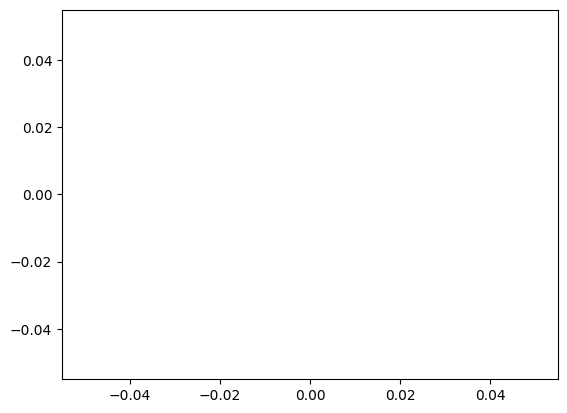


---------fold0---------
train:0.0 valid:0.0



ValueError: Unexpected value for `steps_per_epoch`. Received value is 0. Please check the docstring for `model.fit()` for supported values.

In [ ]:
train_folds(CFG, [0])

In [ ]:
# CFG.seed = 42
# CFG.comment = f'islr-fp16-192-8-seed{CFG.seed}'
# train_folds(CFG, ['all'], summary=False)

In [ ]:
# CFG.seed = 43
# CFG.comment = f'islr-fp16-192-8-seed{CFG.seed}'
# train_folds(CFG, ['all'], summary=False)

In [ ]:
# CFG.seed = 44
# CFG.comment = f'islr-fp16-192-8-seed{CFG.seed}'
# train_folds(CFG, ['all'], summary=False)

In [ ]:
# CFG.seed = 45
# CFG.comment = f'islr-fp16-192-8-seed{CFG.seed}'
# train_folds(CFG, ['all'], summary=False)